# Import libararies

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pickle
import cv2
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
import os
# comment this section if running locally
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download data from kaggle

This code cell will ask the user to upload a json file , the steps to retrieve that json is shown in this link https://www.kaggle.com/discussions/general/74235

In [2]:
!pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d andrewmvd/isic-2019
!unzip /content/isic-2019.zip

Streaming output truncated to the last 5000 lines.
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065374.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019

# Add category label and class number

In [3]:
def preprocess_category_label(x):
    #print(x)
    if x['MEL']==1.0:
        return 'MEL'
    if x['NV']==1.0:
        return 'NV'
    if x['BCC']==1.0:
        return 'BCC'
    if x['AK']==1.0:
        return 'AK'
    if x['BKL']==1.0:
        return 'BKL'
    if x['DF']==1.0:
        return 'DF'
    if x['VASC']==1.0:
        return 'VASC'
    if x['SCC']==1.0:
        return 'SCC'

def preprocess_category_class(x):
    #print(x)
    if x['MEL']==1.0:
        return 1
    if x['NV']==1.0:
        return 2
    if x['BCC']==1.0:
        return 3
    if x['AK']==1.0:
        return 4
    if x['BKL']==1.0:
        return 5
    if x['DF']==1.0:
        return 6
    if x['VASC']==1.0:
        return 7
    if x['SCC']==1.0:
        return 8


# Load  and read ISIC_2019_Training_GroundTruth.csv

In [4]:
gt_csv = '/content/drive/MyDrive/Colab Notebooks/data/ISIC_2019_Training_GroundTruth.csv'
df = pd.read_csv(gt_csv)
df.head()
print(len(df))

25331


In [5]:
df['label'] = df.apply(lambda x:preprocess_category_label(x),axis=1)
df['class_num'] = df.apply(lambda x:preprocess_category_class(x),axis=1)
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label,class_num
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,2
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,2
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,2
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1


In [6]:
df.groupby('label').count()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,class_num
label,,,,,,,,,,,
AK,867,867,867,867,867,867,867,867,867,867,867
BCC,3323,3323,3323,3323,3323,3323,3323,3323,3323,3323,3323
BKL,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624
DF,239,239,239,239,239,239,239,239,239,239,239
MEL,4522,4522,4522,4522,4522,4522,4522,4522,4522,4522,4522
NV,12875,12875,12875,12875,12875,12875,12875,12875,12875,12875,12875
SCC,628,628,628,628,628,628,628,628,628,628,628
VASC,253,253,253,253,253,253,253,253,253,253,253


# Drop UNK column as it is not populated

In [7]:
values_to_keep = ['VASC','DF','AK','BCC','MEL','NV','BKL','SCC']
#values_to_keep = ['MEL','NV','BKL']
df = df.drop(['UNK'],axis=1)
df = df[df['label'].isin(values_to_keep)]

df.groupby('label').count()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,class_num
label,,,,,,,,,,
AK,867,867,867,867,867,867,867,867,867,867
BCC,3323,3323,3323,3323,3323,3323,3323,3323,3323,3323
BKL,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624
DF,239,239,239,239,239,239,239,239,239,239
MEL,4522,4522,4522,4522,4522,4522,4522,4522,4522,4522
NV,12875,12875,12875,12875,12875,12875,12875,12875,12875,12875
SCC,628,628,628,628,628,628,628,628,628,628
VASC,253,253,253,253,253,253,253,253,253,253


# Class distribution of ISIC 2019

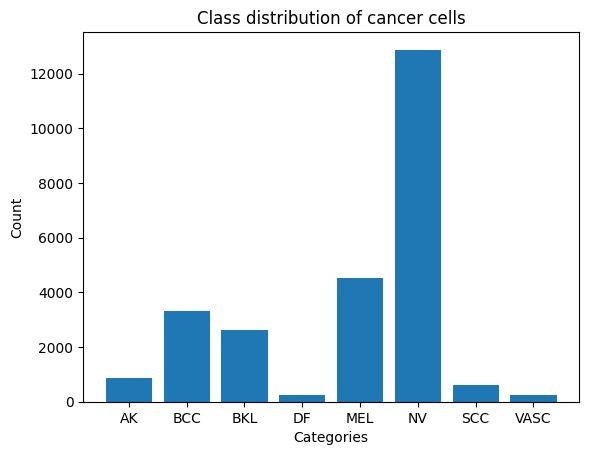

In [8]:
grouped =df.groupby('label').size()

# Plot histogram
plt.bar(grouped.index, grouped.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Class distribution of cancer cells')
plt.show()

# Data point selection
During modelling  we will be applying weighted classification during model training. The max number of samples per class is 1000 as the preprocessing becomes computationally intensive.

In [19]:
# Number of rows per group
n = 1000

# Group the DataFrame based on the 'category' column
grouped = df.groupby('label')

# Group the DataFrame based on the 'category' column
#grouped = df.groupby('category')

# Keep n rows for each category
selected_df = grouped.apply(lambda x: x.head(n))


# Reset the index of the resulting DataFrame
selected_df = selected_df.reset_index(drop=True)#stratified_sample.reset_index(drop=True)

# Concatenate the selected groups into a new DataFrame

selected_df.groupby('label').count()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,class_num
label,,,,,,,,,,
AK,867,867,867,867,867,867,867,867,867,867
BCC,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
BKL,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
DF,239,239,239,239,239,239,239,239,239,239
MEL,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
NV,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
SCC,628,628,628,628,628,628,628,628,628,628
VASC,253,253,253,253,253,253,253,253,253,253


# Generate a stratified train[80%] test[20%] split

In [21]:
train_df, test_df = train_test_split(selected_df, test_size=0.20, stratify=selected_df['label'])

# Class distribution of training set

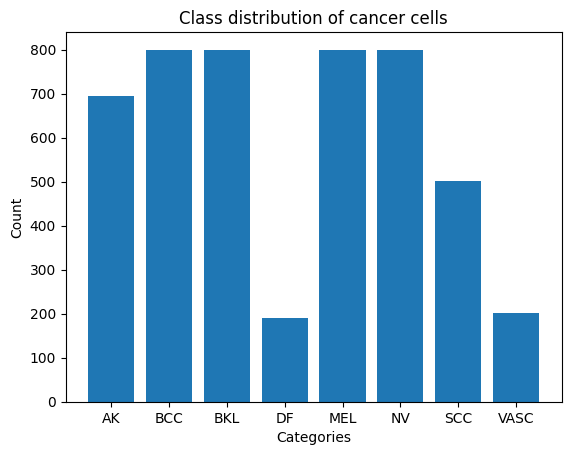

In [24]:
grouped =train_df.groupby('label').size()

# Plot histogram
plt.bar(grouped.index, grouped.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Class distribution of Stratified train set ')
plt.show()

# Class distribution of test set.

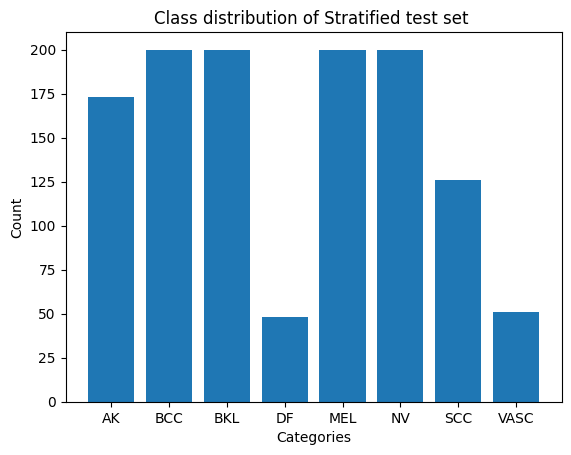

In [25]:
grouped =test_df.groupby('label').size()

# Plot histogram
plt.bar(grouped.index, grouped.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Class distribution of Stratified test set ')
plt.show()

# Preprocessing steps
- Color space correction

- Resize image to (224,224) grid

- Bilateral filtering of images

- Normalizing the image by dividing it by 255.0

In [26]:
data = {}
class_labels = ['MEL','NV','BCC'	,'AK','BKL','DF','VASC','SCC']

features_rgb,features,labels,filenames,class_num_ =[],[],[],[],[]
resized_input_directory = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
resized_mask_directory = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
W = 224
H = 224
for img in train_df.loc[:,['image','label','MEL','NV','BCC'	,'AK','BKL','DF','VASC','SCC','class_num']].values:

    image_path = os.path.join(resized_input_directory, img[0]+'.jpg')
    print('Train prep::',image_path)
    print(image_path)
    image_data_rgb = cv2.imread(image_path,cv2.IMREAD_COLOR)
    print(image_data_rgb.shape)
    image_data_rgb = cv2.cvtColor(image_data_rgb, cv2.COLOR_BGR2RGB)              # Correct Color Space

    image_data_rgb = cv2.resize(image_data_rgb, (H, W))
    image_data_rgb = cv2.bilateralFilter(image_data_rgb, 2, 100, 100)
    image_data_rgb = image_data_rgb.astype('float32')/255.0
    image_data = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
    image_data = cv2.resize(image_data, (H, W))
    image_data = cv2.bilateralFilter(image_data, 2, 100, 100)
    image_data = image_data.astype('float32')/255.0
    #plt.imshow(image_data_rgb)
    class_num = img[9]

    label = img[1]
    one_hot = list(img[2:10])
    print(one_hot)
    filenames.append(img[0])
    labels.append(one_hot)
    features_rgb.append(image_data_rgb)
    features.append(image_data)
    class_num_.append(class_num)

data['train'] =  {'features':features,'features_rgb':features_rgb,'filenames':filenames,'labels':labels,'class_num':class_num_}

features_rgb,features,labels,filenames,class_num_ =[],[],[],[],[]
resized_input_directory = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
resized_mask_directory = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
W = 224
H = 224
for img in test_df.loc[:,['image','label','MEL','NV','BCC'	,'AK','BKL','DF','VASC','SCC','class_num']].values:

    image_path = os.path.join(resized_input_directory, img[0]+'.jpg')
    print('Test prep::',image_path)
    #mask_path = os.path.join(resized_mask_directory, img[0]+'_segmentation.png')
    #print(image_path)
    image_data_rgb = cv2.imread(image_path,cv2.IMREAD_COLOR)
    #print(image_data_rgb.shape)
    image_data_rgb = cv2.cvtColor(image_data_rgb, cv2.COLOR_BGR2RGB)              # Correct Color Space

    image_data_rgb = cv2.resize(image_data_rgb, (H, W))
    image_data_rgb = cv2.bilateralFilter(image_data_rgb, 2, 100, 100)
    image_data_rgb = image_data_rgb.astype('float32')/255.0
    image_data = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
    image_data = cv2.resize(image_data, (H, W))
    image_data = cv2.bilateralFilter(image_data, 2, 100, 100)
    image_data = image_data.astype('float32')/255.0
    #plt.imshow(image_data_rgb)
    class_num = img[9]

    label = img[1]
    one_hot = list(img[2:10])
    print(one_hot)
    filenames.append(img[0])
    labels.append(one_hot)
    features_rgb.append(image_data_rgb)
    features.append(image_data)
    class_num_.append(class_num)


data['test'] = {'features':features,'features_rgb':features_rgb,'filenames':filenames,'labels':labels,'class_num':class_num_}

Streaming output truncated to the last 5000 lines.
Train prep:: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0008552_downsampled.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0008552_downsampled.jpg
(680, 1024, 3)
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Train prep:: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026872.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026872.jpg
(450, 600, 3)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Train prep:: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070999.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070999.jpg
(1024, 1024, 3)
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Train prep:: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0055060.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0055060.jpg
(1024, 1024, 3)
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Train prep:: /content/ISIC_2019_Training

# Save train test sets to a pickle file

In [27]:
#d = {'features':features,'features_rgb':features_rgb,'filenames':filenames,'labels':labels,'class_num':class_num_}
#print(d['labels'].shape)
data['class_labels'] = class_labels
filename = '/content/drive/MyDrive/Colab Notebooks/data/classification_train_test_data.pkl'

# Open the file in binary write mode and pickle the data
with open(filename, 'wb') as file:
    pickle.dump(data, file)

print(f"Data saved as {filename}")



Data saved as /content/drive/MyDrive/Colab Notebooks/data/classification_train_test_data.pkl
